# Assignment 4: Build a Supervised Autoencoder.

### Name: Vatsal Shah

### Due Date: Tuesday 5/3/2022 11:59PM


PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised leanring?



**You are required to build and train a supervised autoencoder look like the following.** You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


## 0. You will do the following:

1. Build a standard dense autoencoder, visual the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.

2. Repeat the above process by training a supervised autoencoder.


## 1. Data preparation

### 1.1. Load data


In [70]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 28*28).astype('float32') / 255.
x_test = x_test.reshape(10000, 28*28).astype('float32') / 255.

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (60000, 784)
Shape of x_test: (10000, 784)
Shape of y_train: (60000,)
Shape of y_test: (10000,)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [71]:
import numpy as np

def to_one_hot(y, num_class=10):
    results = np.zeros((len(y), num_class))
    for i, label in enumerate(y):
        results[i, label] = 1.
    return results

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec: ' + str(y_train_vec.shape))
print('Shape of y_test_vec: ' + str(y_test_vec.shape))

print(y_train[0])
print(y_train_vec[0])

Shape of y_train_vec: (60000, 10)
Shape of y_test_vec: (10000, 10)
5
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 60K training samples to 2 sets:
* a training set containing 10K samples;
* a validation set containing 50K samples. (You can use only 10K to save time.)


In [72]:
rand_indices = np.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

x_val = x_train[valid_indices, :]
y_val = y_train_vec[valid_indices, :]

x_tr = x_train[train_indices, :]
y_tr = y_train_vec[train_indices, :]

print('Shape of x_tr: ' + str(x_tr.shape))
print('Shape of y_tr: ' + str(y_tr.shape))
print('Shape of x_val: ' + str(x_val.shape))
print('Shape of y_val: ' + str(y_val.shape))

Shape of x_tr: (10000, 784)
Shape of y_tr: (10000, 10)
Shape of x_val: (10000, 784)
Shape of y_val: (10000, 10)


## 2. Build an unsupervised  autoencoder and tune its hyper-parameters

1. Build a dense autoencoder model
2. Your encoder should contain 3 dense layers and 1 bottlenect layer with 2 as  output size. 
3. Your decoder should contain 4 dense layers with 784 as output size.
4. You can choose different number of hidden units in dense layers.
5. Do not add other layers (no activation layers), you may add them in later sections.
6. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
    
7. Try to achieve a validation loss as low as possible.
8. Evaluate the model on the test set.
9. Visualize the low-dim features and reconstructions.


### 2.1. Build the model (20 points)

In [119]:
from keras.layers import Dense, Input
from keras import models

input_img = Input(shape=(784,), name='input_img')

encode1 = Dense(128, activation='relu', name='encode1')(input_img)
encode1 = BatchNormalization()(encode1)
encode2 = Dense(32, activation='relu', name='encode2')(encode1)
encode2 = BatchNormalization()(encode2)
encode3 = Dense(8, activation='relu', name='encode3')(encode2)
encode3 = BatchNormalization()(encode3)
bottleneck = Dense(2, activation='relu', name='bottleneck')(encode3)
bottleneck = BatchNormalization()(bottleneck)
decode1 = Dense(8, activation='relu', name='decode1')(bottleneck)
decode1 = BatchNormalization()(decode1)
decode2 = Dense(32, activation='relu', name='decode2')(decode1)
decode2 = BatchNormalization()(decode2)
decode3 = Dense(128, activation='relu', name='decode3')(decode2)
decode3 = BatchNormalization()(decode3)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)
decode4 = BatchNormalization()(decode4)

ae = models.Model(input_img, decode4)

ae.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
batch_normalization_28 (Batc (None, 128)               512       
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32)                128       
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
batch_normalization_30 (Batc (None, 8)                 32 

In [120]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(ae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=ae, show_shapes=False,
    to_file='unsupervised_ae.pdf'
)

# you can find the file "unsupervised_ae.pdf" in the current directory.

### 2.2. Train the model and tune the hyper-parameters (5 points)

In [133]:
from tensorflow.keras import optimizers

learning_rate = 1E-3 # to be tuned!

ae.compile(loss='mean_squared_error',
           optimizer=optimizers.RMSprop(learning_rate=learning_rate))

In [134]:
x_tr.shape

(10000, 784)

In [135]:
history = ae.fit(x_tr, x_tr, 
                 batch_size=256, 
                 epochs=50, 
                 validation_data=(x_val, x_val))

Epoch 1/50
40/40 [==============================] - 3s 22ms/step - loss: 0.0395 - val_loss: 0.0427
Epoch 2/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0386 - val_loss: 0.0412
Epoch 3/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0384 - val_loss: 0.0409
Epoch 4/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0385 - val_loss: 0.0405
Epoch 5/50
40/40 [==============================] - 1s 19ms/step - loss: 0.0383 - val_loss: 0.0404
Epoch 6/50
40/40 [==============================] - 1s 18ms/step - loss: 0.0384 - val_loss: 0.0404
Epoch 7/50
40/40 [==============================] - 1s 16ms/step - loss: 0.0383 - val_loss: 0.0404
Epoch 8/50
40/40 [==============================] - 1s 15ms/step - loss: 0.0384 - val_loss: 0.0403
Epoch 9/50
40/40 [==============================] - 1s 17ms/step - loss: 0.0382 - val_loss: 0.0405
Epoch 10/50
40/40 [==============================] - 1s 15ms/step - loss: 0.0382 - val_loss: 0.0403
Epoch 11/

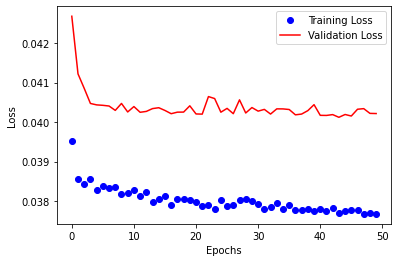

In [136]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 2.3. Visualize the reconstructed test images (5 points)

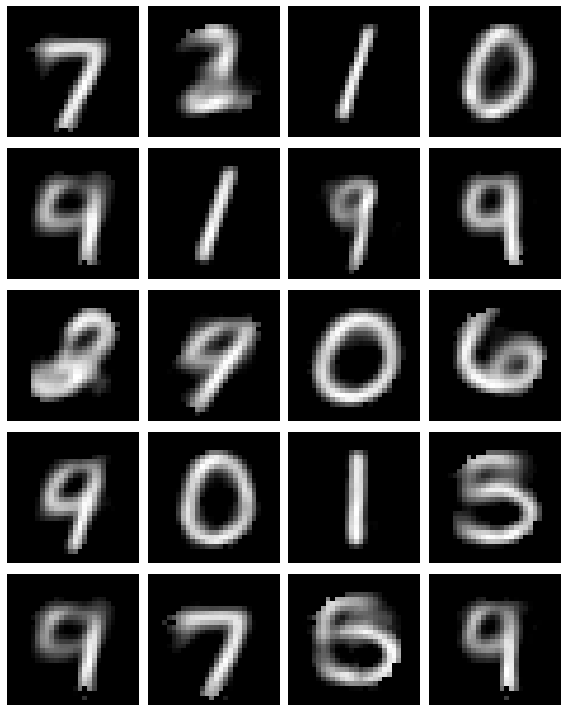

In [137]:
ae_output = ae.predict(x_test).reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = ae_output
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 2.4. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [138]:
loss = ae.evaluate(x_test, x_test)
print('loss = ' + str(loss))

313/313 [==============================] - 1s 2ms/step - loss: 0.0398
loss = 0.03982787951827049


### 2.5. Visualize the low-dimensional features

In [139]:
# build the encoder network
ae_encoder = models.Model(input_img, bottleneck)
ae_encoder.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 128)               100480    
_________________________________________________________________
batch_normalization_28 (Batc (None, 128)               512       
_________________________________________________________________
encode2 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_29 (Batc (None, 32)                128       
_________________________________________________________________
encode3 (Dense)              (None, 8)                 264       
_________________________________________________________________
batch_normalization_30 (Batc (None, 8)                 32 

In [140]:
# extract low-dimensional features from the test data
encoded_test = ae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: (10000, 2)


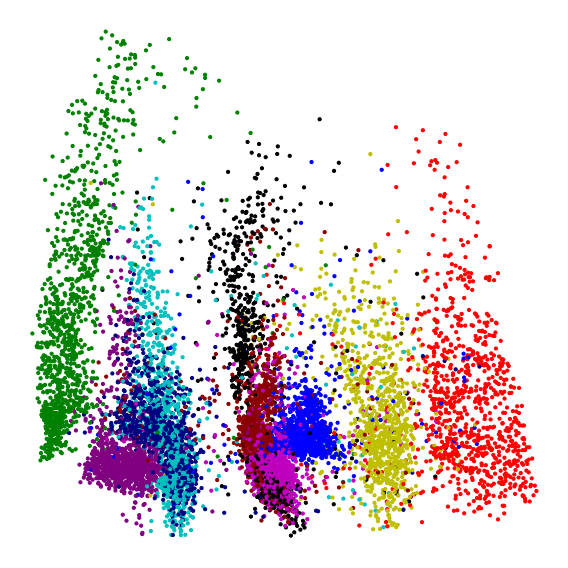

In [141]:
colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
plt.savefig(fname)

#### Remark:

Judging from the visualization, the low-dim features seems not discriminative, as 2D features from different classes are mixed. Let quantatively find out whether they are discriminative.

## 3. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the test set.

In [142]:
# extract the 2D features from the training, validation, and test samples
f_tr = ae_encoder.predict(x_tr)
f_val = ae_encoder.predict(x_val)
f_te = ae_encoder.predict(x_test)

print('Shape of f_tr: ' + str(f_tr.shape))
print('Shape of f_te: ' + str(f_te.shape))

Shape of f_tr: (10000, 2)
Shape of f_te: (10000, 2)


In [143]:
from keras.layers import Dense, Input
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [144]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 2s 5ms/step - loss: 1.9089 - acc: 0.2827 - val_loss: 1.6314 - val_acc: 0.4142
Epoch 2/30
313/313 [==============================] - 1s 5ms/step - loss: 1.4967 - acc: 0.4279 - val_loss: 1.4132 - val_acc: 0.4303
Epoch 3/30
313/313 [==============================] - 1s 4ms/step - loss: 1.3569 - acc: 0.4604 - val_loss: 1.3211 - val_acc: 0.4760
Epoch 4/30
313/313 [==============================] - 1s 4ms/step - loss: 1.2806 - acc: 0.5184 - val_loss: 1.2587 - val_acc: 0.5195
Epoch 5/30
313/313 [==============================] - 1s 5ms/step - loss: 1.2228 - acc: 0.5641 - val_loss: 1.2070 - val_acc: 0.5854
Epoch 6/30
313/313 [==============================] - 1s 4ms/step - loss: 1.1724 - acc: 0.6079 - val_loss: 1.1631 - val_acc: 0.6273
Epoch 7/30
313/313 [==============================] - 1s 4ms/step - loss: 1.1262 - acc: 0.6511 - val_loss: 1.1195 - val_acc: 0.6393
Epoch 8/30
313/313 [==============================] - 1s 4ms/step - loss: 1.

### Conclusion

Using the 2D features, the validation accuracy is 60~70%. Recall that using the original data, the accuracy is about 97%. Obviously, the 2D features are not very discriminative.

We are going to build a supervised autoencode model for learning low-dimensional discriminative features.

## 4. Build a supervised autoencoder model


**You are required to build and train a supervised autoencoder look like the following.** (Not necessary the same. You can use convolutional layers as well.) You are required to add other layers properly to alleviate overfitting.


![Network Structure](https://github.com/wangshusen/CS583A-2019Spring/blob/master/homework/HM5/supervised_ae.png?raw=true "NetworkStructure")


### 4.1. Build the network (30 points)

In [193]:
# build the supervised autoencoder network
from keras.layers import *
from keras import models

input_img = Input(shape=(784,), name='input_img')

# encoder network

encode1 = Dense(256, activation='relu', name='encode1')(input_img)
encode1 = BatchNormalization()(encode1)
encode2 = Dense(128, activation='relu', name='encode2')(encode1)
encode2 = BatchNormalization()(encode2)
encode3 = Dense(32, activation='relu', name='encode3')(encode2)
encode3 = BatchNormalization()(encode3)

# The width of the bottleneck layer must be exactly 2.

bottleneck = Dense(2, activation= 'relu', name= 'bottleneck')(encode3)
bottleneck = BatchNormalization()(bottleneck)

# decoder network
decode1 = Dense(32, activation='relu', name='decode1')(bottleneck)
decode1 = BatchNormalization()(decode1)
decode2 = Dense(128, activation='relu', name='decode2')(decode1)
decode2 = BatchNormalization()(decode2)
decode3 = Dense(256, activation='relu', name='decode3')(decode2)
decode3 = BatchNormalization()(decode3)
decode4 = Dense(784, activation='relu', name='decode4')(decode3)

# build a classifier upon the bottleneck layer
classifier1 = Dense(256, activation='relu', name='classifier1')(bottleneck)
classifier1 = BatchNormalization()(classifier1)
classifier2 = Dense(64, activation='relu', name='classifier2')(classifier1)
classifier2 = BatchNormalization()(classifier2)
classifier3 = Dense(10, activation='softmax', name='classifier3')(classifier2)

In [194]:
# connect the input and the two outputs
sae = models.Model(input_img, [decode4, classifier3])

sae.summary()

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 784)]        0                                            
__________________________________________________________________________________________________
encode1 (Dense)                 (None, 256)          200960      input_img[0][0]                  
__________________________________________________________________________________________________
batch_normalization_86 (BatchNo (None, 256)          1024        encode1[0][0]                    
__________________________________________________________________________________________________
encode2 (Dense)                 (None, 128)          32896       batch_normalization_86[0][0]     
___________________________________________________________________________________________

In [195]:
# print the network structure to a PDF file

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot, plot_model

SVG(model_to_dot(sae, show_shapes=False).create(prog='dot', format='svg'))

plot_model(
    model=sae, show_shapes=False,
    to_file='supervised_ae.pdf'
)

# you can find the file "supervised_ae.pdf" in the current directory.

### 4.2. Train the new model and tune the hyper-parameters

The new model has multiple output. Thus we specify **multiple** loss functions and their weights. 

In [196]:
from tensorflow.keras import optimizers

sae.compile(loss=['mean_squared_error', 'categorical_crossentropy'],
            loss_weights=[1, 0.5], # to be tuned
            optimizer=optimizers.RMSprop(lr=1E-3))

history = sae.fit(x_tr, [x_tr, y_tr], 
                  batch_size=32, 
                  epochs=100, 
                  validation_data=(x_val, [x_val, y_val]))

Epoch 1/100
313/313 [==============================] - 9s 22ms/step - loss: 0.6788 - decode4_loss: 0.0741 - classifier3_loss: 1.2094 - val_loss: 0.8075 - val_decode4_loss: 0.0658 - val_classifier3_loss: 1.4834
Epoch 2/100
313/313 [==============================] - 6s 20ms/step - loss: 0.4068 - decode4_loss: 0.0618 - classifier3_loss: 0.6899 - val_loss: 0.3182 - val_decode4_loss: 0.0605 - val_classifier3_loss: 0.5154
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 0.3326 - decode4_loss: 0.0590 - classifier3_loss: 0.5472 - val_loss: 0.2523 - val_decode4_loss: 0.0613 - val_classifier3_loss: 0.3820
Epoch 4/100
313/313 [==============================] - 7s 21ms/step - loss: 0.2813 - decode4_loss: 0.0581 - classifier3_loss: 0.4464 - val_loss: 0.2376 - val_decode4_loss: 0.0589 - val_classifier3_loss: 0.3573
Epoch 5/100
313/313 [==============================] - 7s 21ms/step - loss: 0.2749 - decode4_loss: 0.0575 - classifier3_loss: 0.4349 - val_loss: 0.2301 - val_de

Epoch 40/100
313/313 [==============================] - 7s 21ms/step - loss: 0.0999 - decode4_loss: 0.0539 - classifier3_loss: 0.0922 - val_loss: 0.1866 - val_decode4_loss: 0.0531 - val_classifier3_loss: 0.2670
Epoch 41/100
313/313 [==============================] - 7s 21ms/step - loss: 0.1001 - decode4_loss: 0.0538 - classifier3_loss: 0.0927 - val_loss: 0.1755 - val_decode4_loss: 0.0537 - val_classifier3_loss: 0.2434
Epoch 42/100
313/313 [==============================] - 7s 21ms/step - loss: 0.0992 - decode4_loss: 0.0538 - classifier3_loss: 0.0909 - val_loss: 0.1867 - val_decode4_loss: 0.0533 - val_classifier3_loss: 0.2668
Epoch 43/100
313/313 [==============================] - 7s 22ms/step - loss: 0.1052 - decode4_loss: 0.0539 - classifier3_loss: 0.1026 - val_loss: 0.1950 - val_decode4_loss: 0.0538 - val_classifier3_loss: 0.2824
Epoch 44/100
313/313 [==============================] - 7s 21ms/step - loss: 0.1046 - decode4_loss: 0.0539 - classifier3_loss: 0.1015 - val_loss: 0.1831 - v

Epoch 79/100
313/313 [==============================] - 9s 28ms/step - loss: 0.0859 - decode4_loss: 0.0530 - classifier3_loss: 0.0659 - val_loss: 0.1836 - val_decode4_loss: 0.0523 - val_classifier3_loss: 0.2625
Epoch 80/100
313/313 [==============================] - 9s 28ms/step - loss: 0.0867 - decode4_loss: 0.0529 - classifier3_loss: 0.0676 - val_loss: 0.1879 - val_decode4_loss: 0.0521 - val_classifier3_loss: 0.2717
Epoch 81/100
313/313 [==============================] - 9s 29ms/step - loss: 0.0824 - decode4_loss: 0.0529 - classifier3_loss: 0.0591 - val_loss: 0.1886 - val_decode4_loss: 0.0522 - val_classifier3_loss: 0.2727
Epoch 82/100
313/313 [==============================] - 9s 29ms/step - loss: 0.0793 - decode4_loss: 0.0527 - classifier3_loss: 0.0531 - val_loss: 0.1862 - val_decode4_loss: 0.0525 - val_classifier3_loss: 0.2675
Epoch 83/100
313/313 [==============================] - 9s 29ms/step - loss: 0.0837 - decode4_loss: 0.0529 - classifier3_loss: 0.0616 - val_loss: 0.1786 - v

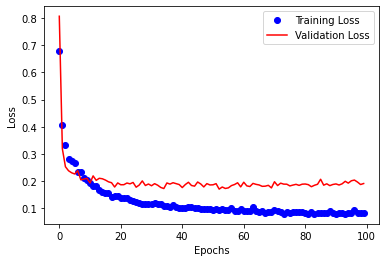

In [197]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question  (10 points)

Do you think overfitting is happening? If yes, what can you do? Please make necessary changes to the supervised autoencoder network structure.

You can use the new model without overfitting for the following sections.

### No, there was no overfitting.

### 4.3. Visualize the reconstructed test images

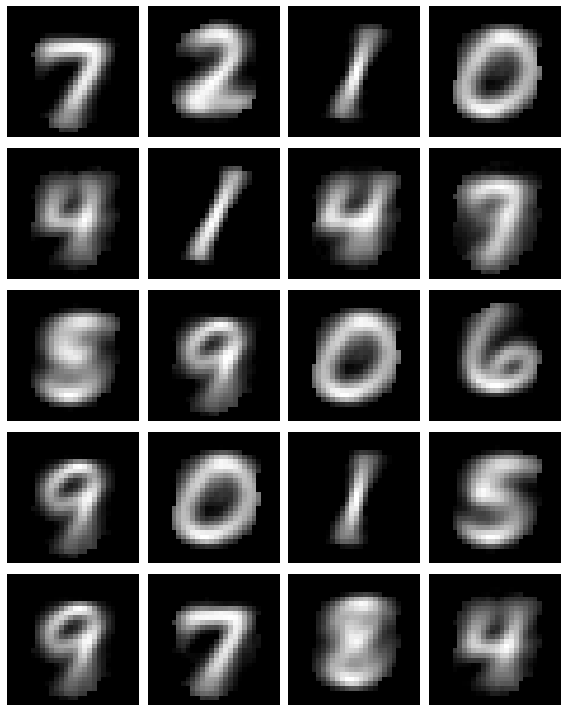

In [198]:
sae_output = sae.predict(x_test)[0].reshape((10000, 28, 28))

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

### 4.4. Visualize the low-dimensional features



In [199]:
# build the encoder model
sae_encoder = models.Model(input_img, bottleneck)
sae_encoder.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 784)]             0         
_________________________________________________________________
encode1 (Dense)              (None, 256)               200960    
_________________________________________________________________
batch_normalization_86 (Batc (None, 256)               1024      
_________________________________________________________________
encode2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_87 (Batc (None, 128)               512       
_________________________________________________________________
encode3 (Dense)              (None, 32)                4128      
_________________________________________________________________
batch_normalization_88 (Batc (None, 32)                128

Shape of encoded_test: (10000, 2)


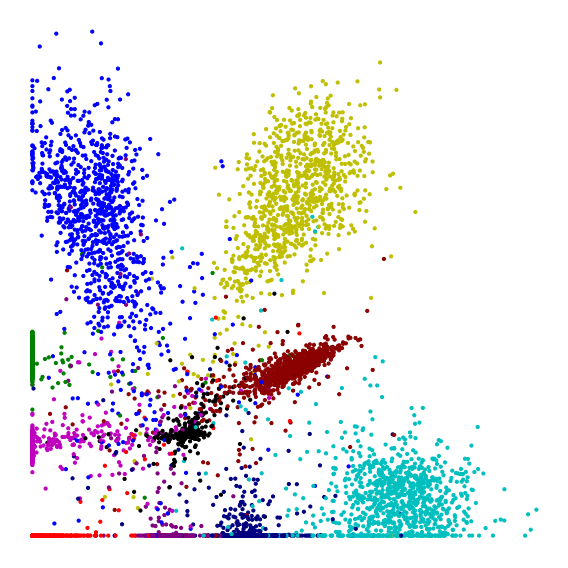

In [200]:
# extract test features
encoded_test = sae_encoder.predict(x_test)
print('Shape of encoded_test: ' + str(encoded_test.shape))

colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[y_test]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
plt.savefig(fname)

### 4.5. Are the learned low-dim features discriminative? (10 points)

To find the answer, lets train a classifier on the training set (the extracted 2-dim features) and evaluation on the validation and test set.



In [201]:
# extract 2D features from the training, validation, and test samples
f_tr = sae_encoder.predict(x_tr)
f_val = sae_encoder.predict(x_val)
f_te = sae_encoder.predict(x_test)

In [215]:
# build a classifier which takes the 2D features as input
from keras.layers import *
from keras import models

input_feat = Input(shape=(2,))

hidden1 = Dense(128, activation='relu')(input_feat)
hidden2 = Dense(128, activation='relu')(hidden1)
output = Dense(10, activation='softmax')(hidden2)

classifier = models.Model(input_feat, output)

classifier.summary()

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               384       
_________________________________________________________________
dense_17 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_18 (Dense)             (None, 10)                1290      
Total params: 18,186
Trainable params: 18,186
Non-trainable params: 0
_________________________________________________________________


In [216]:
classifier.compile(loss='categorical_crossentropy',
                  optimizer=optimizers.RMSprop(lr=1E-4),
                  metrics=['acc'])

history = classifier.fit(f_tr, y_tr, 
                        batch_size=32, 
                        epochs=30, 
                        validation_data=(f_val, y_val))

Epoch 1/30
313/313 [==============================] - 2s 5ms/step - loss: 1.8381 - acc: 0.5044 - val_loss: 1.4548 - val_acc: 0.7606
Epoch 2/30
313/313 [==============================] - 1s 4ms/step - loss: 1.0186 - acc: 0.8876 - val_loss: 0.8051 - val_acc: 0.8596
Epoch 3/30
313/313 [==============================] - 1s 4ms/step - loss: 0.4838 - acc: 0.9363 - val_loss: 0.4681 - val_acc: 0.9374
Epoch 4/30
313/313 [==============================] - 1s 4ms/step - loss: 0.2132 - acc: 0.9958 - val_loss: 0.3359 - val_acc: 0.9407
Epoch 5/30
313/313 [==============================] - 1s 4ms/step - loss: 0.0902 - acc: 0.9972 - val_loss: 0.3085 - val_acc: 0.9416
Epoch 6/30
313/313 [==============================] - 1s 4ms/step - loss: 0.0424 - acc: 0.9974 - val_loss: 0.3239 - val_acc: 0.9422
Epoch 7/30
313/313 [==============================] - 1s 4ms/step - loss: 0.0262 - acc: 0.9975 - val_loss: 0.3475 - val_acc: 0.9427
Epoch 8/30
313/313 [==============================] - 1s 4ms/step - loss: 0.

#### Remark: (10 points)

The validation accuracy must be above 90%. It means the low-dim features learned by the supervised autoencoder are very effective.

In [224]:
# evaluate your model on the never-seen-before test data
# write your code here:
loss = classifier.evaluate(f_te, y_test_vec)

print('Accuracy:', loss[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.5159 - acc: 0.9477
Accuracy: 0.947700023651123
